# York Salary Comparison (Proper Analysis)

Ignoring the fact that the orginal <a href="https://afilazzola.github.io/YorkU.salarycomparison/">analysis</a> appears as if it is being used to argue for an irrelevent conclusion there was quite a large number of poor statistical and logical points being made. I cover some of them here and contrast with the original to highlight the ways it is misleading.

NOTE: A lot of the actually code here is written to optimise for readability.

In [1]:
import numpy as np
import pandas as pd

import pymc3 as pm
import bambi as bam
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as graph
import seaborn as sns


graph.style.use('fivethirtyeight')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/stephen/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
!wc -l Data/*csv

  1554 Data/2012.csv
  1597 Data/2013.csv
  1590 Data/2014.csv
  1610 Data/2015.csv
  1655 Data/2016.csv
  8006 total


In [3]:
# Load Data
df = []
for year in np.arange(2012, 2017):
    df_i = pd.read_csv(f'Data/{year}.csv', index_col=0)
    df.append(df_i)
df = pd.concat(df, ignore_index=True)
df.index = np.arange(len(df))

# Preprocess data
df.rename(columns={'Calendar Year': 'year'}, inplace=True)
df['salary'] = df['Salary Paid'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

display(df.sample(5))
display(df.sort_values('salary', ascending=False).head())

,Salary Paid,Taxable Benefits,Employer,Job Title,year,salary
7886,"$100,865.31",$589.42,York University,Advisor and Deputy Spokesperson,2016,100865.31
6572,"$127,555.56",$738.37,York University,Associate Professor,2016,127555.56
6131,"$178,965.72",$296.20,York University,Professor,2015,178965.72
7613,"$161,534.03",$846.99,York University,Associate Professor,2016,161534.03
2876,"$108,193.16",764.24,York University,Professor,2013,108193.16


,Salary Paid,Taxable Benefits,Employer,Job Title,year,salary
947,"$488,233.57",489.84,York University,Professor,2012,488233.57
1252,"$478,851.66",7665.13,York University,President & Vice Chancellor,2012,478851.66
2839,"$478,405.94",8455.72,York University,President & Vice Chancellor,2013,478405.94
586,"$475,261.83",330.72,York University,Professor / Dean,2012,475261.83
2154,"$475,261.83",568.64,York University,Dean / Professor,2013,475261.83


# First Problem

Summarizing data into averages when you haven't seen the original trend is extremely bad. They tend to make one believe their are strong tends in that maybe not weak trends of no trends at all.

Moreover, the mean is computed for salary data. Since there is always an _a priori_ reason to believe that salary will have a long right tail in it's distribution the mean is misleading.

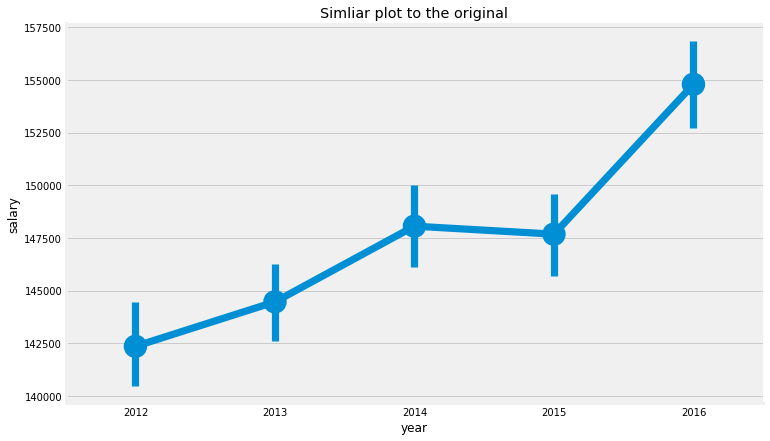

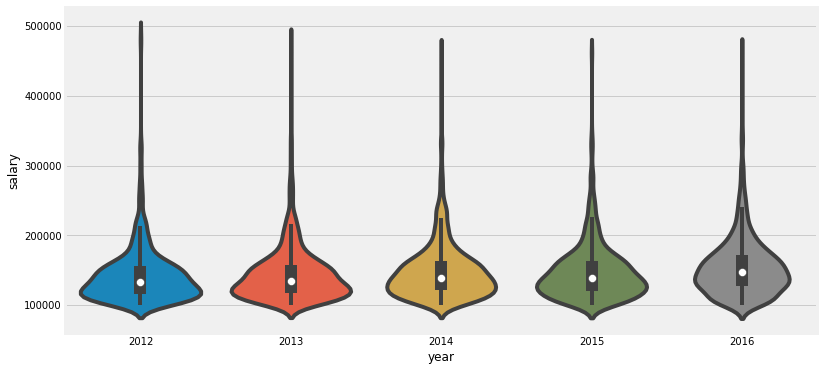

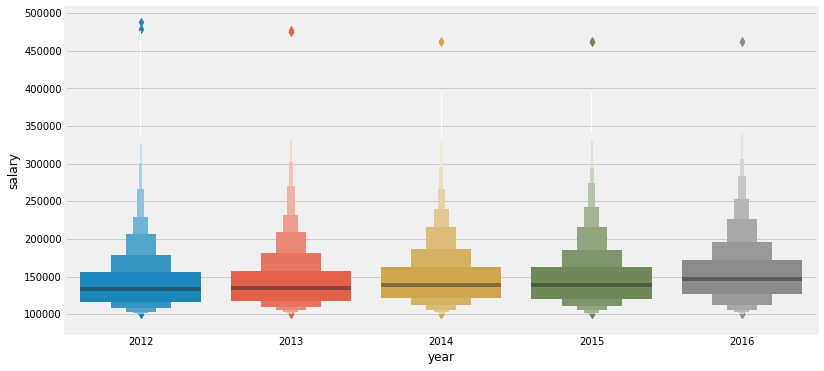

In [4]:
sns.factorplot(x='year', y='salary', data=df, size=6, aspect=1.8)
graph.title('Simliar plot to the original')
graph.show()

graph.figure(figsize=(12, 6))
sns.violinplot(x='year', y='salary', data=df)
graph.show()

graph.figure(figsize=(12, 6))
sns.lvplot(x='year', y='salary', data=df)
graph.show()

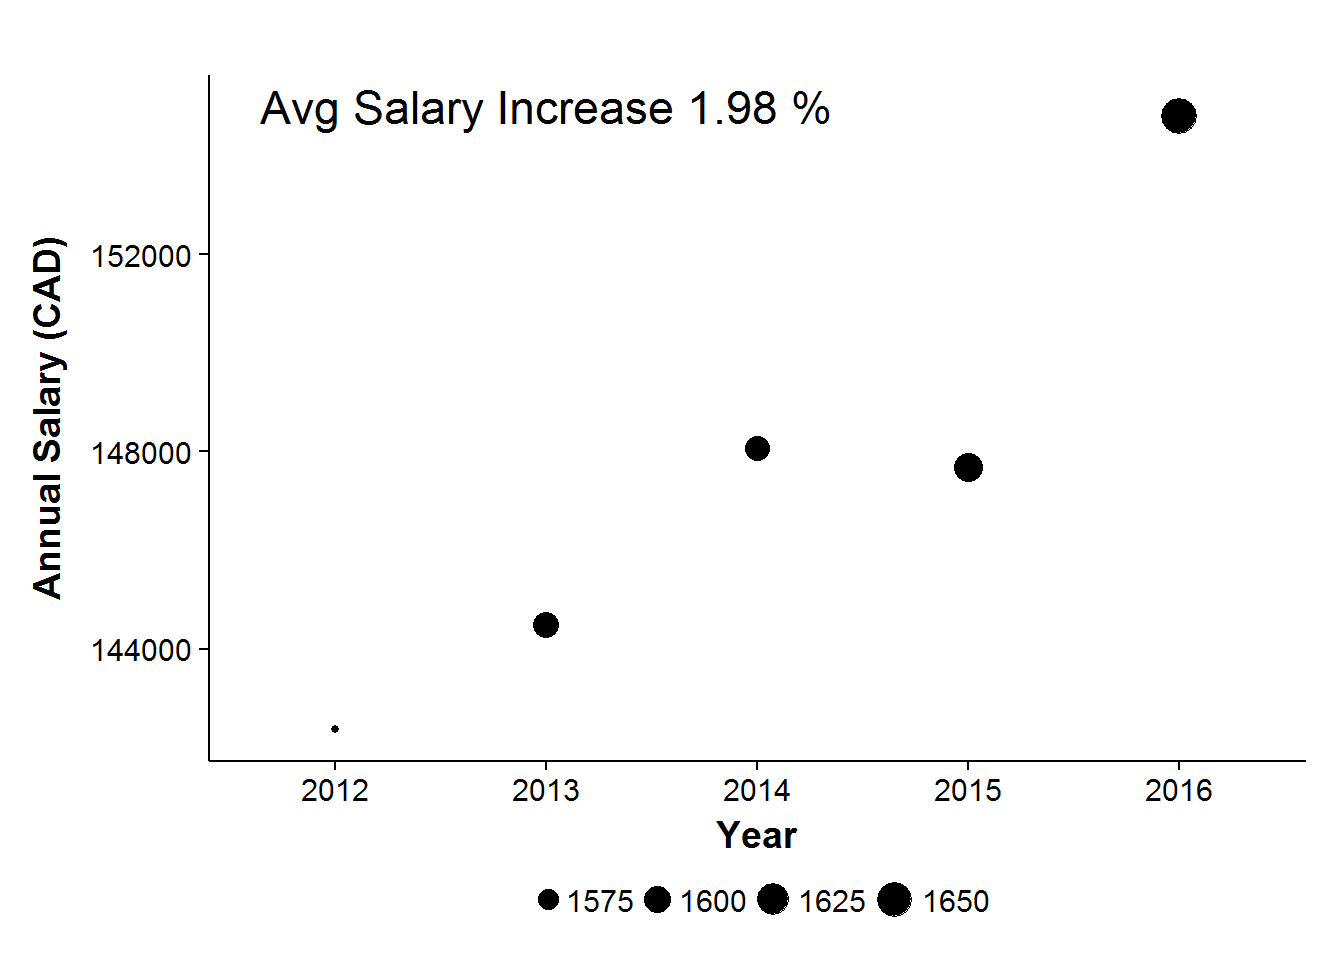

Notice how when you can see the spread of the real data the 'trends' seen in the original analysis appears extremely weak. Also you notice that the amount paid to the highest paid individual decreases as time progresses. 

# Second Problem

The original analysis then tries to analysis the salary trends of "Upper-administration". The original operational definition was those who are "not teaching staff, professors, lower management, engineers, or technicians". Instead of simply selecting these individuals to does another kind of selection.

I execute this selection properly an compare the results.

In [5]:
def is_upper_administration(x):
    x = x.lower()
    
    # First exclude (This excludes provosts that are also professors)
    exclude = [(e in x) for e in ['professor', 'engineer', 'technician']]
    if any(exclude):
        return False
    
    # Now select
    include = [(e in x) for e in ['executive']]
    if any(include):
        return True
    else:
        return False
    
df['upper_admin'] = df['Job Title'].apply(lambda x: is_upper_administration(x))
display(df.sample(5))

,Salary Paid,Taxable Benefits,Employer,Job Title,year,salary,upper_admin
3012,"$144,759.18",696.64,York University,Professor,2013,144759.18,False
24,"$119,137.33",288.82,York University,Senior Director Alumni Relations,2012,119137.33,False
2602,"$126,238.17",390.33,York University,Professor,2013,126238.17,False
5412,"$160,626.48",$872.44,York University,Senior Librarian,2015,160626.48,False
7406,"$208,800.03","$1,192.28",York University,Associate Professor,2016,208800.03,False


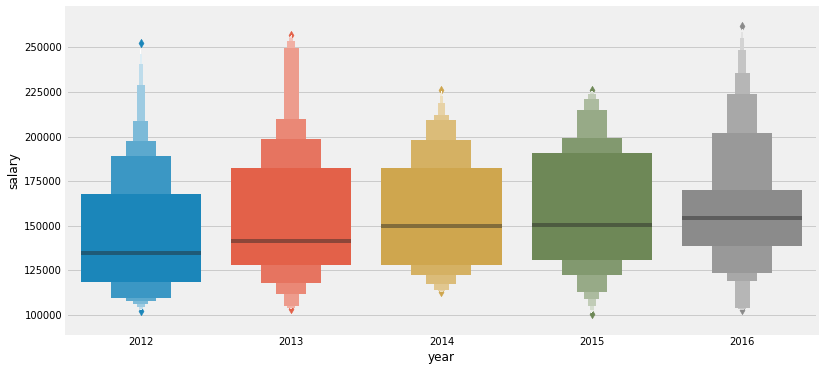

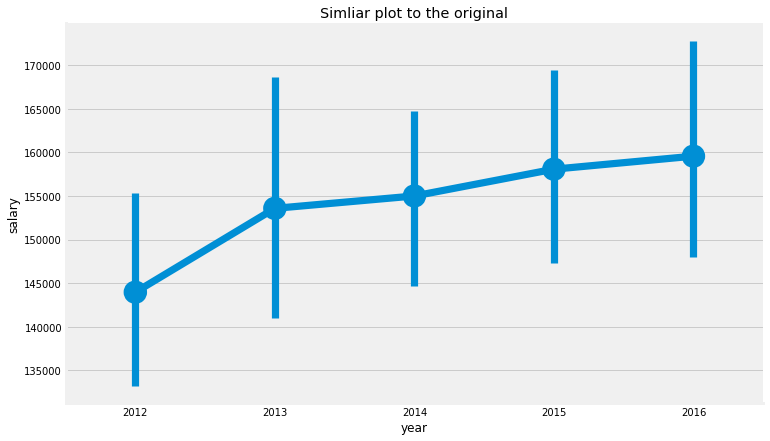

In [6]:
graph.figure(figsize=(12, 6))
sns.lvplot(x='year', y='salary', data=df.query('upper_admin == True'))
graph.show()

sns.factorplot(x='year', y='salary', data=df.query('upper_admin == True'), size=6, aspect=1.8)
graph.title('Simliar plot to the original')
graph.show()

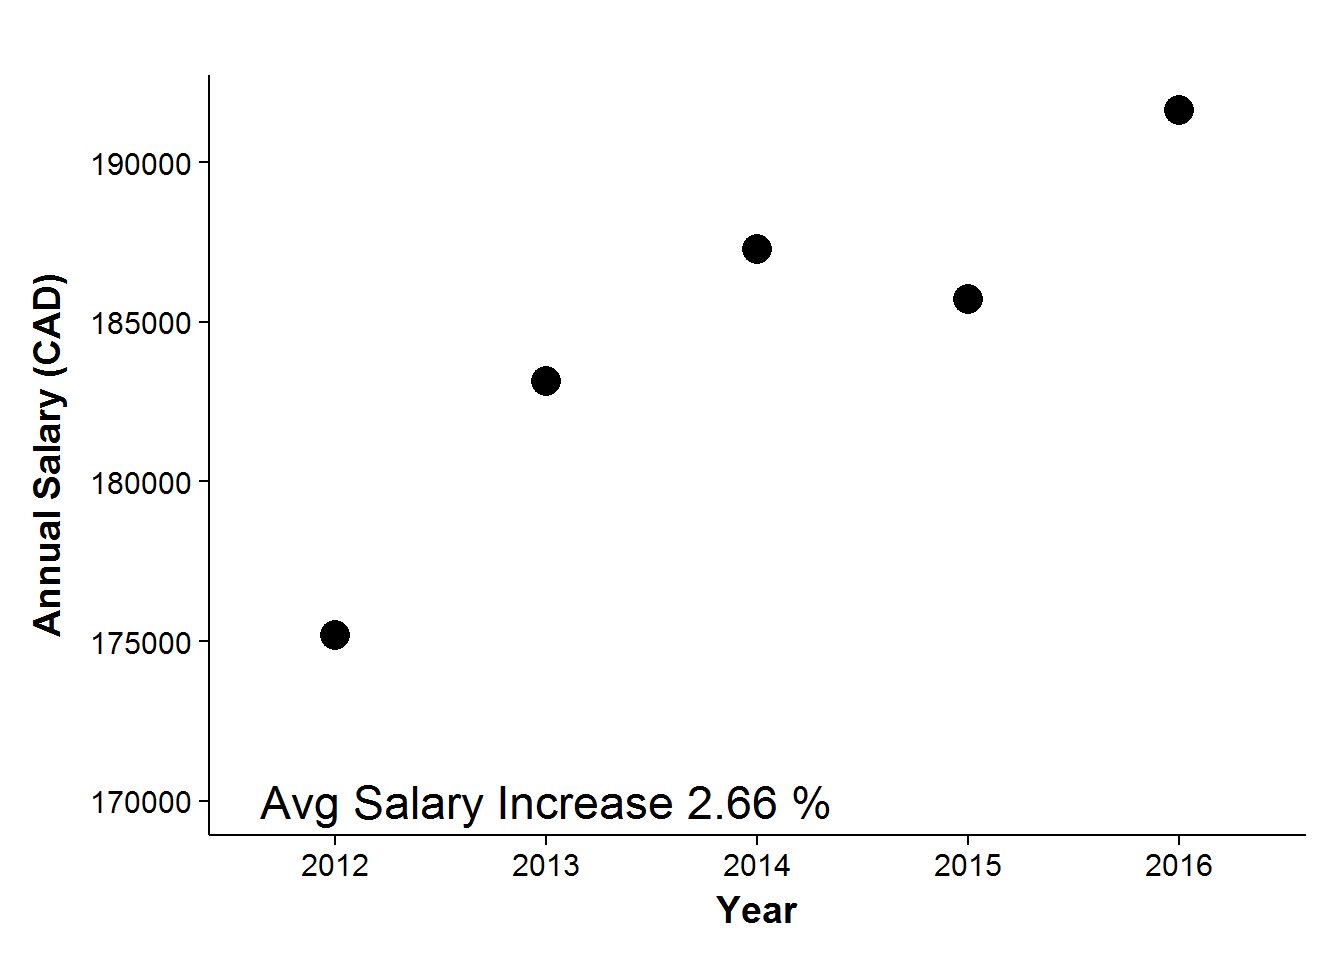

Even plotting just the means gives different results and 'trends' from just ensuring that data selection was done properly.

Now let's also see what it looks like when "Upper-admin" is removed from the original plot.

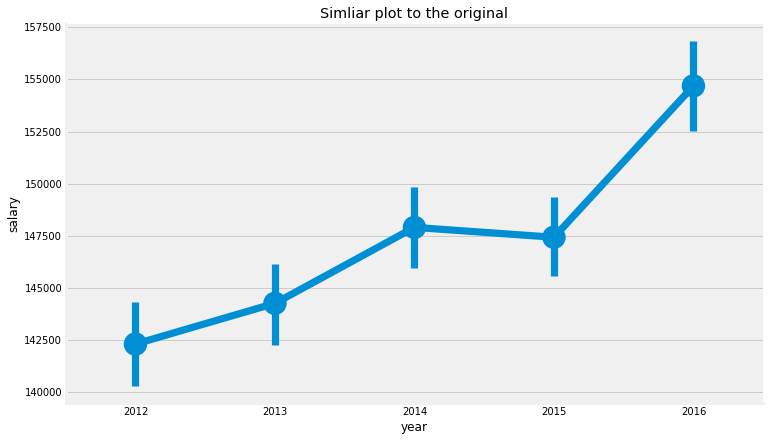

In [7]:
sns.factorplot(x='year', y='salary', data=df.query('upper_admin == False'), size=6, aspect=1.8)
graph.title('Simliar plot to the original')
graph.show()

With upper admin removed it looks like salaries here are growing faster than the upper administration's salaries. We'll have to do real statistics to check this however.

I'll fit on the summarised data like the original analysis did but perform a random walk rather than a naive mean of the year by year differences.

Admin = [0.03597394]
Non = [0.02245765]


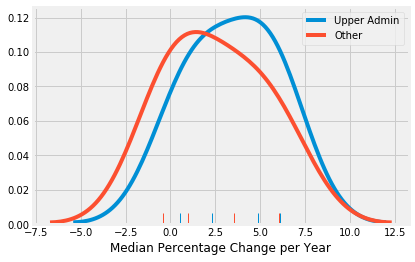

t-Test p-value = [0.64540606]


In [8]:
# What the original analysis could have done as table stakes
ab_test = []
for admin in [True, False]:
    df_i = df.query(f'upper_admin == {admin}')
    df_i = df_i.groupby('year').agg(['median'])
    
    data = df_i['salary'].pct_change().dropna()
    print(f'{"Admin" if admin else "Non"} = {data.median().values}')
    ab_test.append(data)
    
    sns.distplot(
        data*100, 
        hist=False, rug=True,
        label='Upper Admin' if admin else 'Other'
    )
graph.xlabel('Median Percentage Change per Year')
graph.show()

# Classic test to check whether 2 means are different?
t_test = stats.ttest_ind(ab_test[0], ab_test[1], equal_var=False)
print(f't-Test p-value = {t_test.pvalue}')

It t-Test was unsurprisingly non-significant due to the fact that the sample size was so incredibility small. But even by eye the differences in the median salaries are neglecible. That being said if I had to bet I would say that upper admin gets a larger raise. This however is not found in data.

Probably the largest piece of accidental obfuscation is not presenting the raw salaries on the same graph at the same time. Of course here I will do that.

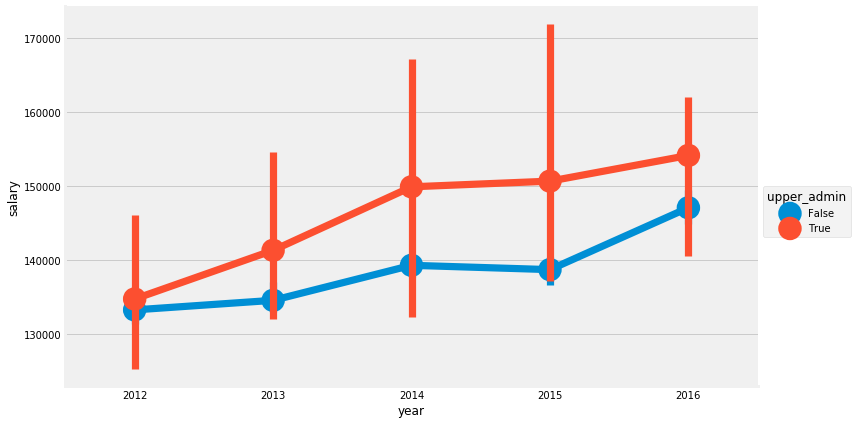

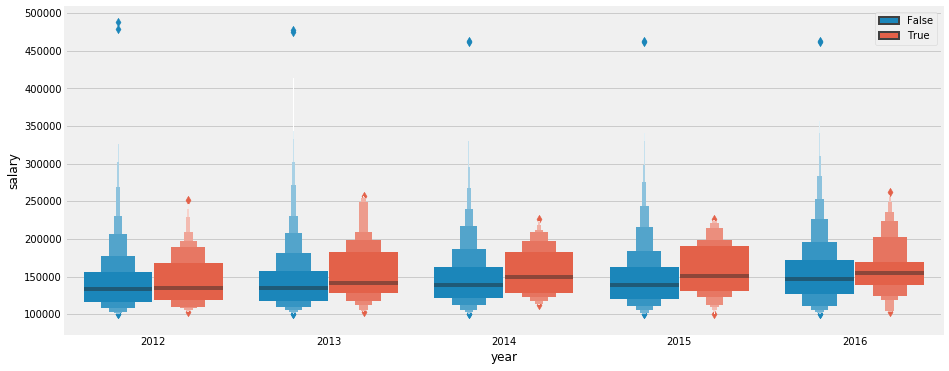

In [9]:
sns.factorplot(x='year', y='salary', hue='upper_admin', estimator=np.median, data=df, size=6, aspect=1.8)
graph.show()

graph.figure(figsize=(14, 6))
sns.lvplot(x='year', y='salary', hue='upper_admin', data=df)
graph.legend(loc='upper right')
graph.show()

,Salary Paid,Taxable Benefits,Employer,Job Title,year,salary,upper_admin,norm_salary
3639,"$126,279.32",$643.40,York University,Associate Professor,2014,126279.32,False,0.947526
5913,"$171,139.98",$989.74,York University,Professor,2015,171139.98,False,1.284134
5676,"$108,819.96",$-,York University,Senior Account Executive / Account Support Adv...,2015,108819.96,True,0.807589


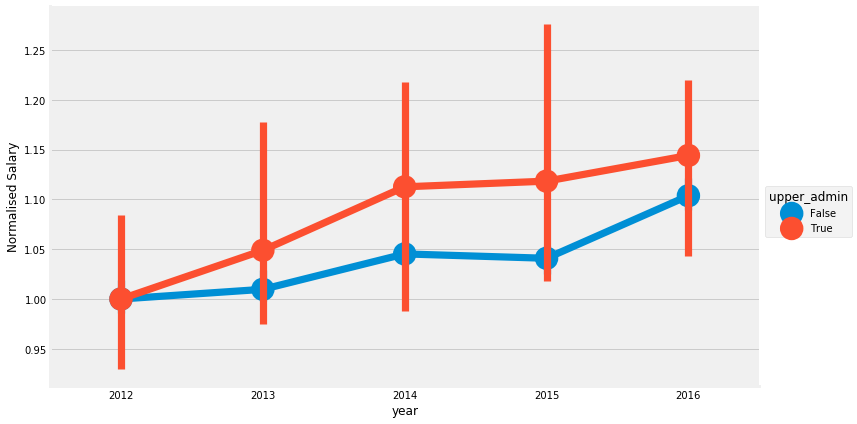

In [10]:
# Normalise Salary Groups
admin_denom = df.query('year == 2012 & upper_admin == True')['salary'].median()
non_admin_denom = df.query('year == 2012 & upper_admin == False')['salary'].median()
def normalise_salary(row):
    if row['upper_admin']:
        return row['salary'] / admin_denom
    else:
        return row['salary'] / non_admin_denom

df['norm_salary'] = df.apply(lambda x: normalise_salary(x), axis='columns')
display(df.sample(3))


sns.factorplot(x='year', y='norm_salary', hue='upper_admin', data=df, estimator=np.median, size=6, aspect=1.8)
graph.ylabel('Normalised Salary')
graph.show()

In [11]:
admin_results = smf.quantreg('norm_salary ~ year', data=df.query('upper_admin == True')).fit()
display(admin_results.summary())

non_admin_results = smf.quantreg('norm_salary ~ year', data=df.query('upper_admin == False')).fit()
display(non_admin_results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:            norm_salary   Pseudo R-squared:              0.02459
Model:                       QuantReg   Bandwidth:                      0.2367
Method:                 Least Squares   Sparsity:                       0.6531
Date:                Mon, 02 Apr 2018   No. Observations:                  176
Time:                        14:53:05   Df Residuals:                      174
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -71.8879     34.908     -2.059      0.041    -140.786      -2.990
year           0.0362      0.017      2.090      0.038       0.002       0.070
==============================================================================

The condition number is large, 2.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:            norm_salary   Pseudo R-squared:             0.007830
Model:                       QuantReg   Bandwidth:                     0.05742
Method:                 Least Squares   Sparsity:                       0.6223
Date:                Mon, 02 Apr 2018   No. Observations:                 7825
Time:                        14:53:06   Df Residuals:                     7823
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.7311      5.006     -9.136      0.000     -55.544     -35.918
year           0.0232      0.002      9.344      0.000       0.018       0.028
==============================================================================

The condition number is large, 2.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

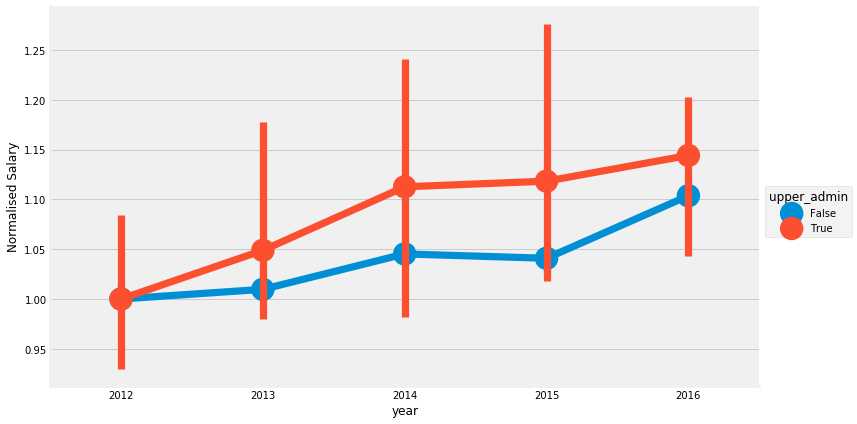

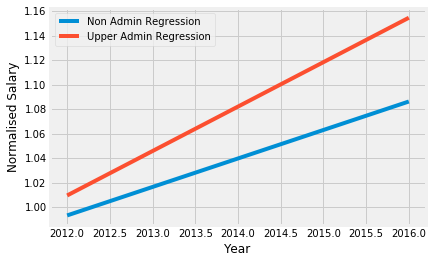

In [12]:
xs = np.linspace(2012, 2016, 100)

sns.factorplot(x='year', y='norm_salary', hue='upper_admin', data=df, estimator=np.median, size=6, aspect=1.8)
graph.ylabel('Normalised Salary')
graph.show()

graph.plot(
    xs, non_admin_results.params['year'] * xs + non_admin_results.params['Intercept'], 
    label='Non Admin Regression'
)
graph.plot(
    xs, admin_results.params['year'] * xs + admin_results.params['Intercept'], 
    label='Upper Admin Regression'
)
graph.ylabel('Normalised Salary')
graph.xlabel('Year')
graph.legend()
graph.show()

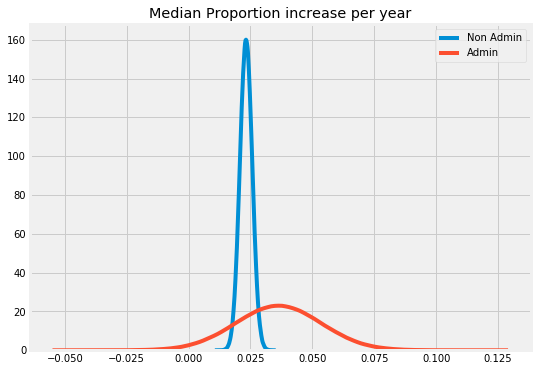

P(Admin > Non-admin) = 77.165%


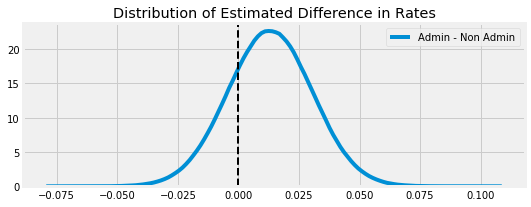

In [13]:
# Coef
samples = int(1e6)
admin_coef = stats.norm(admin_results.params['year'], admin_results.bse['year']).rvs(samples)
non_admin_coef = stats.norm(non_admin_results.params['year'], non_admin_results.bse['year']).rvs(samples)

graph.figure(figsize=(8, 6))
graph.title('Median Proportion increase per year')
sns.distplot(non_admin_coef, hist=False, label='Non Admin')
sns.distplot(admin_coef, hist=False, label='Admin')
graph.legend()
graph.show()

# Probability Upper Admin > Non-admin
print(f'P(Admin > Non-admin) = {(admin_coef > non_admin_coef).mean()*100:0.3f}%')

graph.figure(figsize=(8, 3))
graph.title('Distribution of Estimated Difference in Rates')
sns.distplot(admin_coef - non_admin_coef, hist=False, label='Admin - Non Admin')
graph.axvline(0, linestyle='--', color='k', linewidth=2)
graph.legend()
graph.show()

Now we have estimates about the rate in which the median salaries increase each year. And we are also fairly sure that the rate of median growth of admin salaries are larger than those of the non-admin.

# Conclusion

**TL;DR The fundamental analytical problem with the original analysis was that he confused longitudal with anonymous data.** 

The biggest thing I wish could have been done different would be to track the individual's salaries from year to year. While it is true that the original analysis did not want to include names simply encoding the names with unique IDs would have done the job while allowing you to answer the question that was originally set out to answer.

If I were going to spend another hour on this I would go get the data with names and actually answer if one group is getting more raises than another.